# Data

In [1]:
import os 
import numpy as np
import cv2 as cv
import tensorflow as tf


def load_data(lst_path_x, lst_path_y):
    images = []
    labels = []
    i = 0
    l = len(lst_path_x)
    for x,y in zip(lst_path_x, lst_path_y):
        images.append(cv.resize(cv.imread(x),(512,512)))
        labels.append(cv.resize(cv.imread(y),(512,512)))
        if i % (l/100) == 0: 
          print(f"------loading - {i*100/l} %-----")
        i+=1
        

    return np.asarray(images),np.asarray(labels)

def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (512, 512), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (512, 512), method='nearest')
    
    return image, mask
        
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset



# Model

In [2]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from keras import backend as keras
import tensorflow as tf



def unet(pretrained_weights = None, input_size = (256,256,3), filters=32, n_classes=10):
    
        inputs = Input(input_size)
        # Encoder
        inputs = Lambda(lambda x:x/255)(inputs)
        conv1 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        conv2 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        conv3 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        conv4 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        #decoder
        up6 = Conv2D(filters*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(filters*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(filters*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
       
        conv10 = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(n_classes, 1, activation = 'sigmoid')(conv10)

        model = Model(inputs = inputs, outputs = conv10)
            
        #binary_crossentropy,sparse_categorical_crossentropy,categorical_crossentropy
        model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        
        #model.summary()

        if(pretrained_weights):
            model.load_weights(pretrained_weights)
            
        return model

# Main 

In [3]:
# image_path = ["/content/data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
# mask_path = ["/content/data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [4]:
from google.colab.patches import cv2_imshow

image_path = "/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/image_2/"
mask_path = "/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/semantic/"
  
lst_train_x = sorted([image_path + f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))])
lst_train_y = sorted([mask_path + f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

print(len(lst_train_x),len(lst_train_y))


200 200


In [5]:
from sklearn.model_selection import train_test_split
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(lst_train_x, lst_train_y, test_size=0.2, random_state=42)
test_image_paths, validation_image_paths, test_mask_paths, validation_mask_paths = train_test_split(test_image_paths, test_mask_paths, test_size=0.5, random_state=42)

In [6]:
print(f"X_train size: {len(train_image_paths)}, X_val size: {len(validation_image_paths)}, X_test size: {len(test_image_paths)}")

X_train size: 160, X_val size: 20, X_test size: 20


In [7]:
batch_size = 10
buffer_size = 20

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

In [8]:
train_dataset

<BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.uint8)>

------loading - 0.0 %-----


<Figure size 720x720 with 0 Axes>

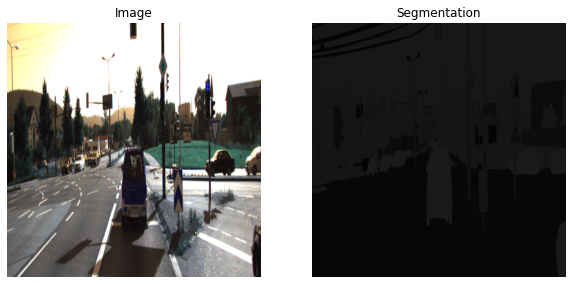

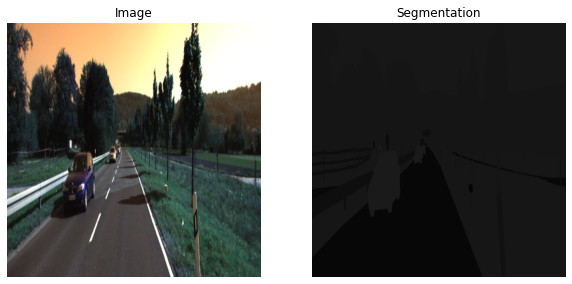

In [9]:
import matplotlib.pyplot as plt

dataset = load_data(test_image_paths, test_mask_paths)

idx = 0
plt.figure(figsize=(10, 10))
for images, lables in zip(dataset[0],  dataset[1]):
    fig, arr = plt.subplots(1, 2 , figsize=(10, 10))
    arr[0].imshow(images)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(lables)
    arr[1].set_title('Segmentation')
    arr[1].axis("off") 
    idx +=1
    if idx ==2:
      break

In [10]:
# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

img_height = 512
img_width = 512
num_channels = 3
filters = 32
n_classes = 50

model = unet(input_size = (img_height, img_width, num_channels), filters=filters, n_classes=n_classes)

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
model_checkpoint = ModelCheckpoint('kitti-unet-semantic-model.h5', monitor='loss',verbose=1, save_best_only=True)
batch_size = 10
epochs = 30
history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr, model_checkpoint], 
                    batch_size = batch_size,
                    shuffle = True)

Epoch 1/30
 1/16 [>.............................] - ETA: 29:26 - loss: 4.1047 - accuracy: 0.1777

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('kitti-unet-semantic-model.h5')

In [ ]:
batch_size = 20
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = batch_size)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = batch_size)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = batch_size)

In [ ]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

# Predict image segmentations using the trained Model

In [ ]:
model = load_model('kitti-unet-semantic-model.h5')

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask[0]

In [ ]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def show_predictions(sample_image):
    """
    Displays the first image of each of the num batches
    """
    sample_image = cv.resize(sample_image,(512,512))
    display([sample_image,
          create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
from skimage import io
url = "https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/images/car-reviews/first-drives/legacy/1_city_car.jpg?itok=1xuVdW-Z"
print(f"downloading {url}")
img_sample = io.imread(url)
show_predictions(img_sample)